In [22]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow as tf
import pathlib
import numpy as np

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D, MaxPool2D

from keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import np_utils
from keras.applications.resnet50 import ResNet50

from keras.datasets import cifar10
from keras.datasets import mnist

In [23]:
#Checking that TensorFlow can find a GPU
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [24]:
#Directories for training and test images, each has 23 sub folders each corresponding to a classification category
train_dir = pathlib.Path('data/train')
test_dir = pathlib.Path('data/test')

In [25]:
#Variables for Later
classes = len(os.listdir(train_dir))
im_rows, im_cols = 64, 64
batch_size = 32
dropout_fc = 0.5
dropout_cnn = 0.25
epochs = 25
train_image_count = len(list(train_dir.glob('*/*.jpg')))
test_image_count = len(list(test_dir.glob('*/*.jpg')))

print("Number of Training Images: ", train_image_count)
print("Number of Test Images: ", test_image_count)
print("Number of Classes: ", classes)

Number of Training Images:  15557
Number of Test Images:  3946
Number of Classes:  23


In [26]:
#Image Data generator that augments images as they're fed into the Neural Network
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    shear_range = 0.3,
    zoom_range = 0.3,
    rotation_range = 30,
    horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [27]:
#Generate test and training data, keeping colormode RGB as color is important in this imageset
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(im_rows,im_cols),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(im_rows,im_cols),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

Found 15557 images belonging to 23 classes.
Found 3946 images belonging to 23 classes.


In [28]:
#Function to build and Compile Neural Network

def build_cnn(im_x, im_y, im_z, dropout_fc, dropout_cnn, classes, model_name, has_callbacks):

    my_model  =  Sequential()
#CNN Input Lyaer
    my_model.add(Conv2D(32, 3, padding = 'same', kernel_initializer = 'he_normal', input_shape = (im_x, im_y, im_z)))
    my_model.add(Activation('elu'))
    my_model.add(BatchNormalization())
    my_model.add(Conv2D(32, 3, padding = 'same', kernel_initializer = 'he_normal', input_shape = (im_x, im_y, im_z)))
    my_model.add(Activation('elu'))
    my_model.add(BatchNormalization())
    my_model.add(MaxPooling2D(pool_size = 2))
    my_model.add(Dropout(dropout_cnn))

#CNN Layer 2
    my_model.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal'))
    my_model.add(Activation('elu'))
    my_model.add(BatchNormalization())
    my_model.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal'))
    my_model.add(Activation('elu'))
    my_model.add(BatchNormalization())
    my_model.add(MaxPooling2D(pool_size = 2))
    my_model.add(Dropout(dropout_cnn))

#CNN Layer 3
    my_model.add(Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal'))
    my_model.add(Activation('elu'))
    my_model.add(BatchNormalization())
    my_model.add(Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal'))
    my_model.add(Activation('elu'))
    my_model.add(BatchNormalization())
    my_model.add(MaxPooling2D(pool_size = 2))
    my_model.add(Dropout(dropout_cnn))

#CNN Layer 4
    my_model.add(Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal'))
    my_model.add(Activation('elu'))
    my_model.add(BatchNormalization())
    my_model.add(Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal'))
    my_model.add(Activation('elu'))
    my_model.add(BatchNormalization())
    my_model.add(MaxPooling2D(pool_size = 2))
    my_model.add(Dropout(dropout_cnn))

#FC Layer 1
    my_model.add(Flatten())
    my_model.add(Dense(64, kernel_initializer = 'he_normal'))
    my_model.add(Activation('elu'))
    my_model.add(BatchNormalization())
    my_model.add(Dropout(dropout_fc))

#FC Layer 2
    my_model.add(Dense(64, kernel_initializer = 'he_normal'))
    my_model.add(Activation('elu'))
    my_model.add(BatchNormalization())
    my_model.add(Dropout(dropout_fc))

#Output Layer
    my_model.add(Dense(classes, kernel_initializer = 'he_normal'))
    my_model.add(Activation('softmax'))
    
    #Early stop and weight saving on epochs
#If using callbacks will return callback object and model otherwise just the model
    if has_callbacks is True:
        
        checkpoint = ModelCheckpoint(
            model_name + '.h5',
            monitor='val_loss',
            mode='min',
            save_best_only=True,
            verbose=1)

        earlystop = EarlyStopping(
            monitor='val_loss',
            min_delta=0.01,
            patience=4,
            verbose=1,
            restore_best_weights=True)

        callbacks = [earlystop, checkpoint]

        my_model.compile(
            loss='categorical_crossentropy',
            optimizer = 'adam',
            metrics=['accuracy'])

        return my_model, callbacks
    
    else:
        my_model.compile(
            loss='categorical_crossentropy',
            optimizer = 'adam',
            metrics=['accuracy'])
            
        return my_model

In [29]:
#Building and compiling custom CNN from function, viewing result
my_model, callback = build_cnn(im_rows, im_cols, 3, dropout_fc, dropout_cnn, classes, 'my_model', True)
print(my_model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
activation_125 (Activation)  (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_23 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
activation_126 (Activation)  (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 32, 32, 32)       

In [30]:
#Fit
history_new_model=my_model.fit(
    train_generator,
    steps_per_epoch=train_image_count//batch_size,
    epochs=epochs,
    callbacks=callback,
    validation_data=test_generator,
    validation_steps=test_image_count//batch_size)


Epoch 1/25
486/486 [==============================] - 78s 162ms/step - loss: 3.6598 - accuracy: 0.0802 - val_loss: 2.9516 - val_accuracy: 0.1418

Epoch 00001: val_loss improved from inf to 2.95164, saving model to my_model.h5
Epoch 2/25
486/486 [==============================] - 76s 156ms/step - loss: 3.0515 - accuracy: 0.1219 - val_loss: 2.8682 - val_accuracy: 0.1507

Epoch 00002: val_loss improved from 2.95164 to 2.86817, saving model to my_model.h5
Epoch 3/25
486/486 [==============================] - 75s 155ms/step - loss: 2.9031 - accuracy: 0.1421 - val_loss: 2.9814 - val_accuracy: 0.1464

Epoch 00003: val_loss did not improve from 2.86817
Epoch 4/25
486/486 [==============================] - 75s 155ms/step - loss: 2.8304 - accuracy: 0.1612 - val_loss: 2.5129 - val_accuracy: 0.1643

Epoch 00004: val_loss improved from 2.86817 to 2.51286, saving model to my_model.h5
Epoch 5/25
486/486 [==============================] - 76s 156ms/step - loss: 2.7910 - accuracy: 0.1712 - val_loss: 2.

In [31]:
#Function for Visualizing Accuracy and Loss per Epoch
def plot_accuracy_loss(history):
    acc = list(np.array(history.history['accuracy']) * 100)
    
    loss = history.history['loss']
    
    epochs_range = range(len(acc))

    plt.figure(figsize = (12, 4))
    plt.subplot(1, 2, 1)
    sns.lineplot(x = epochs_range, y = acc, label = 'Training Accuracy')
    
    if len(history.history.keys()) > 2:
        val_acc = list(np.array(history.history['val_accuracy']) * 100)
        sns.lineplot(x = epochs_range, y = val_acc, label = 'Validation Accuracy')
    
    plt.xticks(epochs_range)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy in %")
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    sns.lineplot(x = epochs_range, y = loss, label = 'Training Loss')
    
    if len(history.history.keys()) > 2:
        val_loss = history.history['val_loss']
        sns.lineplot(x = epochs_range, y = val_loss, label = 'Validation Loss')
    
    plt.xticks(epochs_range)
    plt.xlabel("Epoch")
    plt.ylabel("Loss Magnitude")
    plt.legend(loc = 'upper right')
    plt.title('Training and Validation Loss')
    
    plt.show()

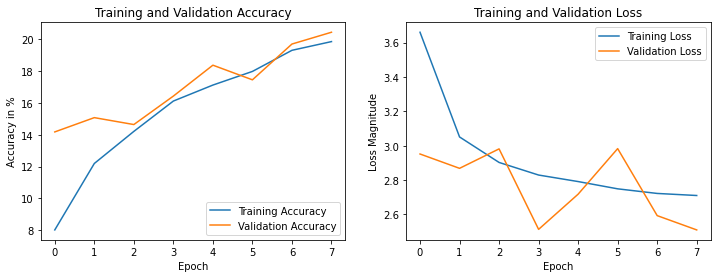

In [32]:
plot_accuracy_loss(history_new_model)

The accuracy for my model isn't nearly what I hoped for, with a validation accuracy of roughly 20% it's about 5 times greater than random chance but not nearly enough to feel confident.  My guess is that the data is the issue. Next I will perform transfer learning using a ResNet50 model to compare to my model and see how well it performs with the dataset.

In [43]:
#Function to Build and compile ResNet50 Model for transfer learning

def build_resnet(im_x, im_y, im_z, dropout_fc, dropout_cnn, classes, model_name, has_callbacks):

    #instanciating ResNet50 model with default imagenet weights
    resnet = ResNet50( 
        include_top = False, 
        input_shape = (im_x, im_y, im_z))

    #Setting layers of transfer learning model to untrainable to not overwrite weights
    #for layer in resnet.layers:
    #    layer.trainable = False

#Building FC & output to tack onto the end of the ResNet Network
    resnet_model = Sequential()

    resnet_model.add(resnet)

    #Only using one FC Layer, 2 were tried and didn't improve results and could lead to over fitting

    #1st Layer
    resnet_model.add(Flatten())       
    resnet_model.add(Dense(512, kernel_initializer='he_normal'))
    resnet_model.add(Activation('elu'))
    resnet_model.add(BatchNormalization())
    resnet_model.add(Dropout(dropout_fc))

    #Output Layer
    resnet_model.add(Dense(classes, kernel_initializer='he_normal'))
    resnet_model.add(Activation('softmax'))

#Early stop and weight saving on epochs
#If using callbacks will return callback object and model otherwise just the model
    if has_callbacks is True:
        
        checkpoint_resnet = ModelCheckpoint(
            model_name + '.h5',
            monitor='val_loss',
            mode='min',
            save_best_only=True,
            verbose=1)

        earlystop_resnet = EarlyStopping(
            monitor='val_loss',
            min_delta=0.01,
            patience=4,
            verbose=1,
            restore_best_weights=True)

        callbacks_res = [earlystop_resnet, checkpoint_resnet]

        resnet_model.compile(
            loss='categorical_crossentropy',
            optimizer = 'adam',
            metrics=['accuracy'])

        return resnet_model, callbacks_res
    
    else:
        resnet_model.compile(
            loss='categorical_crossentropy',
            optimizer = 'adam',
            metrics=['accuracy'])
        
        return resnet_model

In [44]:
#Building and compiling Resnet Transfer Learning model from function, viewing result
resnet_model, callbacks_resnet = build_resnet(im_rows, im_cols, 3, dropout_fc, dropout_cnn, classes, 'resnet_model', True)
print(resnet_model.summary())

C:\Users\RyanJ\anaconda3\envs\PythonGPU\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten_9 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               4194816   
_________________________________________________________________
activation_298 (Activation)  (None, 512)               0         
_________________________________________________________________
batch_normalization_45 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_29 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 23)               

In [45]:
#Fitting ResNet50 model
history_resnet_model = resnet_model.fit(
    train_generator,
    steps_per_epoch = train_image_count//batch_size,
    epochs = epochs,
    callbacks = callbacks_resnet,
    validation_data = test_generator,
    validation_steps = test_image_count//batch_size)

Epoch 1/25
486/486 [==============================] - 88s 180ms/step - loss: 3.4928 - accuracy: 0.1232 - val_loss: 3.0137 - val_accuracy: 0.0866

Epoch 00001: val_loss improved from inf to 3.01373, saving model to resnet_model.h5
Epoch 2/25
486/486 [==============================] - 81s 166ms/step - loss: 3.2605 - accuracy: 0.1420 - val_loss: 3.0107 - val_accuracy: 0.1275

Epoch 00002: val_loss improved from 3.01373 to 3.01069, saving model to resnet_model.h5
Epoch 3/25
486/486 [==============================] - 81s 166ms/step - loss: 3.1241 - accuracy: 0.1637 - val_loss: 2.8592 - val_accuracy: 0.1482

Epoch 00003: val_loss improved from 3.01069 to 2.85918, saving model to resnet_model.h5
Epoch 4/25
486/486 [==============================] - 81s 166ms/step - loss: 3.0789 - accuracy: 0.1685 - val_loss: 62.9815 - val_accuracy: 0.1027

Epoch 00004: val_loss did not improve from 2.85918
Epoch 5/25
486/486 [==============================] - 81s 166ms/step - loss: 3.0604 - accuracy: 0.1620 -

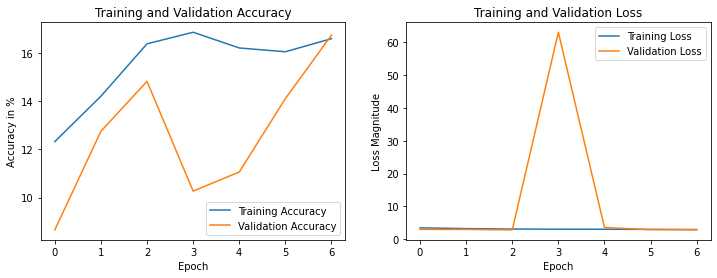

In [46]:
plot_accuracy_loss(history_resnet_model)

The ResNet50 model has a large discrepancy between the training and validation loss & accuracy.  To combat the overfitting I tried additional data augmentation techniques and removing one of the FC layers and although the training accuracy increased, the validation accuracy delta remained large.  Because of the overfitting occuring I think fine tuning would make the problem worse.  I will perform one final test using both models on the CIFAR10 image dataset to verify the models work and that the skin disease dataset is the issue.

In [37]:
# Loading and tweaking cifar10 Dataset for compiling and fitting

(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

#generating variables for easy re-use
train_num, row, col, chan = X_train.shape
test_num = X_test.shape[0]
batch_size_t = 50

#reshaping label data to match the right categories
y_train = np_utils.to_categorical(Y_train)
y_test = np_utils.to_categorical(Y_test)

classes_t = y_test.shape[1]

In [38]:
#Data generators that use the same augmentation as the skin disease dataset
train_generator_cifar10 = train_datagen.flow(
    X_train,
    y_train,
    batch_size=batch_size_t,
    shuffle=True)
    
test_generator_cifar10 = test_datagen.flow(
    X_test,
    y_test,
    batch_size=batch_size_t,
    shuffle=True)

In [39]:
#Build, Compile & Fit cifar10 data to my model
cifar10_my_model, callback_cifar10 = build_cnn(row, col, chan, dropout_fc, dropout_cnn, classes_t, 'cifar10_my_model', True)

history_cifar10_my_model = cifar10_my_model.fit(
    train_generator_cifar10,
    steps_per_epoch=train_num//batch_size_t,
    epochs=epochs,
    callbacks=callback_cifar10,
    validation_data=test_generator_cifar10,
    validation_steps=test_num//batch_size_t)

Epoch 1/25
1000/1000 [==============================] - 23s 23ms/step - loss: 1.9711 - accuracy: 0.3186 - val_loss: 1.6482 - val_accuracy: 0.4907

Epoch 00001: val_loss improved from inf to 1.64819, saving model to cifar10_my_model.h5
Epoch 2/25
1000/1000 [==============================] - 21s 21ms/step - loss: 1.4940 - accuracy: 0.4663 - val_loss: 1.1915 - val_accuracy: 0.5287

Epoch 00002: val_loss improved from 1.64819 to 1.19148, saving model to cifar10_my_model.h5
Epoch 3/25
1000/1000 [==============================] - 21s 21ms/step - loss: 1.3254 - accuracy: 0.5398 - val_loss: 1.3425 - val_accuracy: 0.5556

Epoch 00003: val_loss did not improve from 1.19148
Epoch 4/25
1000/1000 [==============================] - 21s 21ms/step - loss: 1.1988 - accuracy: 0.5898 - val_loss: 1.3763 - val_accuracy: 0.6407

Epoch 00004: val_loss did not improve from 1.19148
Epoch 5/25
1000/1000 [==============================] - 21s 21ms/step - loss: 1.1239 - accuracy: 0.6214 - val_loss: 0.7408 - val_a

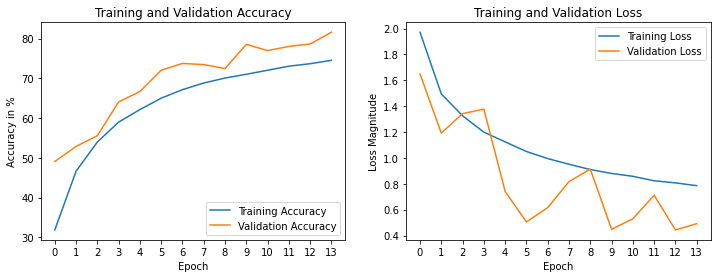

In [40]:
plot_accuracy_loss(history_cifar10_my_model)

In [47]:
#Fitting and training cifar10 dataset with ResNet50 Model
cifar10_resnet_model, callback_cifar10 = build_resnet(row, col, chan, dropout_fc, dropout_cnn, classes_t, 'cifar10_resnet_model',True)

history_cifar10_resnet_model = cifar10_my_model.fit(
    train_generator_cifar10,
    steps_per_epoch=train_num//batch_size_t,
    epochs=epochs,
    callbacks=callback_cifar10,
    validation_data=test_generator_cifar10,
    validation_steps=test_num//batch_size_t)

C:\Users\RyanJ\anaconda3\envs\PythonGPU\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Epoch 1/25
1000/1000 [==============================] - 22s 22ms/step - loss: 0.7941 - accuracy: 0.7415 - val_loss: 0.7065 - val_accuracy: 0.7765

Epoch 00001: val_loss improved from inf to 0.70646, saving model to cifar10_resnet_model.h5
Epoch 2/25
1000/1000 [==============================] - 22s 22ms/step - loss: 0.7707 - accuracy: 0.7494 - val_loss: 0.2759 - val_accuracy: 0.7980

Epoch 00002: val_loss improved from 0.70646 to 0.27593, saving model to cifar10_resnet_model.h5
Epoch 3/25
1000/1000 [==============================] - 22s 22ms/step - loss: 0.7494 - accuracy: 0.7569 - val_loss: 0.5048 - val_accuracy: 0.8084

Epoch 00003: val_loss did not improve from 0.27593
Epoch 4/25
1000/1000 [==============================] - 22s 22ms/step - loss: 0.7404 - accuracy: 0.7611 - val_loss: 0.5510 - val_accuracy: 0.8310

Epoch 00004: val_loss did not improve from 0.27593
Epoch 5/25
1000/1000 [==============================] - 22s 22ms/step - loss: 0.7269 - accuracy: 0.7646 - val_loss: 0.4253

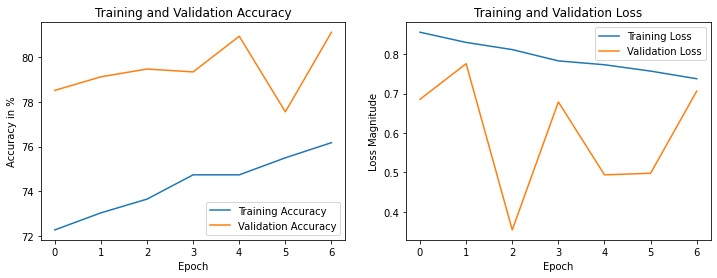

In [42]:
plot_accuracy_loss(history_cifar10_resnet_model)

You can see both models produces over 80% validation accuracy on the cifar10 image dataset.  The issue with the Skin Disease data is that it is too varied and needs further sub-classification.